In [0]:
!unzip -q '/content/human_seg.zip'

In [0]:
import os
#os.chdir("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2, keras

from glob import glob

from lib import *

%matplotlib inline

In [15]:
add_path = os.getcwd()
print(add_path)

/content


In [6]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 


In [0]:
import os
import numpy as np

from glob import glob
from PIL import Image
from datetime import datetime


def generate_html(path_to_data):
    """Generates content of html file and saves it.

    Parameters
    ----------
    path_to_data : str
        Path to data with original images, predicted masks, and cropped according masks images.

    Returns
    -------
    str
        Content of html file.

    """
    html = "\n".join(["<!doctype html>", "<html>", "<head>",
                      "<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>",
                      "<title>Визуализация результатов</title>", "</head>", "<body>",
                      "<table cellspacing='0' cellpadding='5'>"]) + "\n"
    paths_to_imgs = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_img.jpg")])
    paths_to_masks = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_pred_mask.png")])
    paths_to_crops = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_crop.png")])
    for ind, (path_to_img, path_to_mask, path_to_crop) in enumerate(zip(paths_to_imgs,
                                                                        paths_to_masks,
                                                                        paths_to_crops)):
        if not ind % 2:
            html += "<tr>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_img}'"
        html += "alt='Something went wrong.'"
        html += f"height='320' title='Original image:\n{path_to_img}'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_mask}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Predicted mask'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_crop}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Cropped img according\npredicted mask'></td>\n"
        if not ind % 2:
            html += "<td width='100'></td>\n"
        else:
            html += "</tr>\n"
    date = datetime.today().strftime("%Y-%m-%d-%H.%M.%S")
    html += f"</table>\n<i>The page was generated at {date}</i></body>\n</html>"
    filename = os.path.basename(path_to_data) + ".html"
    path_to_save = os.path.dirname(path_to_data)
    with open(f"{path_to_save}/{filename}", "w") as f:
        f.write(html)

    return html


def get_html(paths_to_imgs, pred_masks, path_to_save="results/test"):
    """Generates html file and saves it.

    Parameters
    ----------
    paths_to_imgs : list[str]
        List of paths to original images.
    pred_masks : list[np.ndarray]
        Predicted masks.
    path_to_save : str
        Path to save source images to put them in html file. Html name is the same as name of the
        last folder on `path_to_save` and is saved on upper level.

    Returns
    -------
    str
        Content of html file.

    """
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

    html = generate_html(path_to_save)

    return html

In [0]:
import numpy as np


EPS = 1e-10


def dice(true, pred):
    """Dice score.

    Parameters
    ----------
    true : np.ndarray, 2d
         Ground truth mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.
    pred : np.ndarray, 2d
         Predicted mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.

    Returns
    -------
    float from 0 to 1
        Dice score. The greater the value of dice score the better.

    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).

    """
    true = true.astype(bool)
    pred = pred.astype(bool)

    intersection = (true & pred).sum()
    im_sum = true.sum() + pred.sum()

    return 2.0 * intersection / (im_sum + EPS)


def get_dice(true, pred):
    """Mean dice score.

    Parameters
    ----------
    true : list[np.ndarray] or np.ndarray
         List of ground truth masks or one mask that consists of 2 unique values:
         0 - denotes background, 1 - denotes object.
    pred : list[np.ndarray] or np.ndarray
         List of predicted masks or one mask that consists of 2 unique values:
         0 - denotes background, 1 - denotes object.

    Returns
    -------
    float from 0 to 1
        Dice score or mean dice score in case then lists of masks are passed.
        The greater the value of dice score the better.

    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).
    
    """
    assert type(true) == type(pred), "Types of true and pred should be the same."
    if isinstance(true, list):
        return np.mean([dice(t, p) for t, p in zip(true, pred)])
    elif isinstance(true, np.ndarray):
        return dice(true, pred)
    else:
        raise TypeError("Wrong type.")

In [0]:
import matplotlib.pyplot as plt


def show_img_with_mask(img, mask, figsize=(14, 8)):
    """Shows image and mask.

    Parameters
    ----------
    img : np.ndarray
        Image.
    mask : np.ndarray
        Mask.
    figsize : tuple of 2 int, optional (default=(14, 8))
        Figure size.

    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img)
    ax2.imshow(mask)
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

In [0]:
import numpy as np


def encode_rle(mask):
    """Returns encoded mask (run length) as a string.

    Parameters
    ----------
    mask : np.ndarray, 2d
        Mask that consists of 2 unique values: 0 - denotes background, 1 - denotes object.

    Returns
    -------
    str
        Encoded mask.

    Notes
    -----
    Mask should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).

    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)


def decode_rle(rle_mask, shape=(320, 240)):
    """Decodes mask from rle string.

    Parameters
    ----------
    rle_mask : str
        Run length as string formatted.
    shape : tuple of 2 int, optional (default=(320, 240))
        Shape of the decoded image.

    Returns
    -------
    np.ndarray, 2d
        Mask that contains only 2 unique values: 0 - denotes background, 1 - denotes object.
    
    """
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for low, high in zip(starts, ends):
        img[low:high] = 1

    return img.reshape(shape)

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Данные, метрики и доступные функции

Посмотрим на данные:

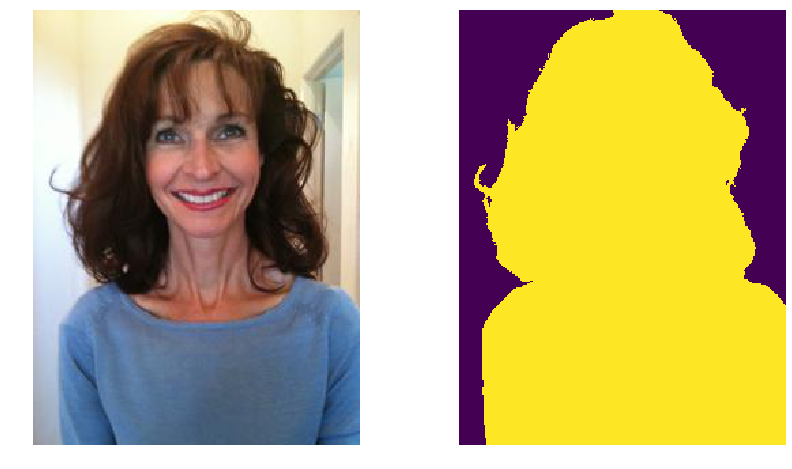

In [16]:
path = add_path + "/data/train"
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)

Пример подсчета метрики:

In [17]:
random_mask = np.random.randint(low=0, high=2, size=mask.shape)
get_dice(mask, random_mask)

0.5953763305145351

Можно для последовательности масок вычислить среднее значение метрики:

In [18]:
random_masks_1 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
random_masks_2 = [np.random.randint(low=0, high=2, size=mask.shape) for i in range(10)]
get_dice(random_masks_1, random_masks_2)

0.5007232038231919

Пример использования функций `encode_rle` и `decode_rle`:
1. Функция `encode_rle` используется для кодирования маски в строку для последующей записи в файл;
2. Функция `decode_rle` используется для восстановления маски по закодированной строке.

In [19]:
rle_mask = encode_rle(mask)
rle_mask

'114 34 354 37 595 37 835 41 1074 43 1312 45 1537 1 1539 1 1548 50 1599 1 1775 4 1781 58 1840 1 2013 68 2249 72 2488 74 2726 77 2964 79 3203 80 3442 82 3680 84 3919 86 4158 87 4397 88 4637 89 4875 91 5115 92 5353 95 5593 95 5832 97 6071 98 6310 101 6550 101 6789 103 7029 106 7269 108 7509 109 7746 1 7748 110 7986 1 7988 111 8226 1 8228 111 8467 114 8707 115 8945 117 9185 118 9424 120 9664 120 9903 122 10144 121 10380 1 10383 123 10620 127 10862 126 11101 126 11341 126 11580 128 11819 128 12059 128 12298 129 12538 129 12776 131 13016 131 13255 132 13495 133 13735 136 13974 138 14212 141 14453 140 14693 141 14932 143 15172 143 15412 143 15651 145 15891 146 16131 148 16371 149 16611 150 16850 151 17090 152 17330 152 17488 2 17491 1 17570 154 17728 4 17810 157 17968 2 18050 160 18291 158 18530 159 18768 162 19009 162 19237 1 19248 163 19477 1 19489 163 19717 2 19728 164 19957 2 19967 165 20196 6 20207 165 20437 5 20444 1 20446 167 20677 5 20683 1 20685 169 20917 5 20924 170 21157 5 21163 1

Теперь восстановим маску:

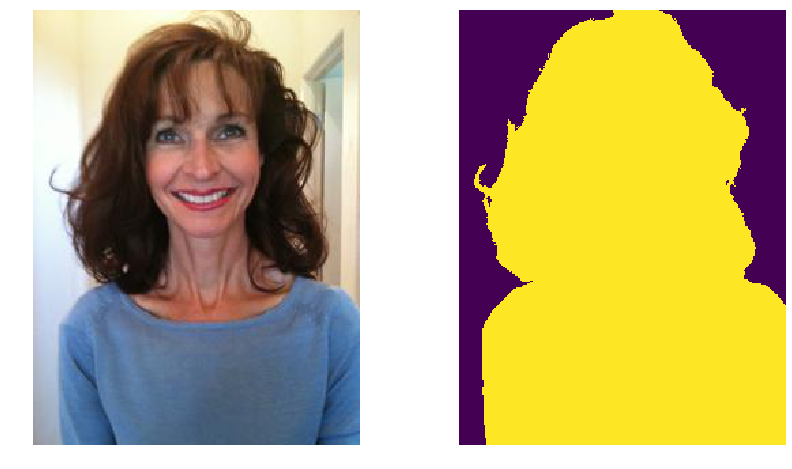

In [20]:
decoded_mask = decode_rle(rle_mask)
show_img_with_mask(img, decoded_mask)

---

# Результаты

Пример файла для изображений из `data/valid`:  
_Каждую предсказанную маску для изображения из `valid` необходимо закодировать и записать в показанный ниже файл, который служит примером, именно в таком виде нужно будет представить результат Вашего лучшего решения на данных из `valid`._

In [21]:
pred = pd.read_csv("data/pred_valid_template.csv")
pred.head()

,id,rle_mask
0,1315,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
1,1316,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
2,1317,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
3,1318,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...
4,1319,9706 7 9939 15 9974 8 10174 20 10214 13 10412 ...


Для данных из `test` требуется создать html страницу + картинки для нее.  
Это можно сделать с помощью функции `get_html`, как показано ниже.

In [0]:
paths_to_imgs = sorted(glob("data/valid/*"))
#print(paths_to_imgs)
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/valid_mask/*"))]

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example")

В папке `results` создался файл `example.html` и папка `examples` с используемыми картинками.

************************

# Решение задачи


Перед тем как приступить к задаче проведем анализ статей и учебных материалов по смежным темам, а именно:  
* Статья по Unet: https://arxiv.org/pdf/1505.04597.pdf
* Статья по SegNet: https://arxiv.org/pdf/1511.00561.pdf
* Видео лекция Deep Learning School по сегментации: https://www.youtube.com/watch?v=OWK8VlgJM4I
* Статья по библиотке albumentations: https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac

В результате было решено придерживаться  следующего подхода:  
1. Использовать pre-trained модель, ввиду ограниченных вычислительных ресурсов
2. Для упрощения работы с сегментационными моделями(подбор backbone для них) установить библиотеку Segmentation Models (https://github.com/qubvel/segmentation_models)
3. Для упрощения работы по аугментации данных использовать библиотеку albumentations (https://github.com/albu/albumentations)
4. Для предложенной задачи попробовать две архитектуры сетей: SegNet и Unet с различными backbone

# Препроцессинг и анализ данных

Посмотрим на размеры датасетов, убедимся, что количество изображений соответствует количеству масок:

In [23]:
#path = "data/train"

train_files = [f for f in glob('data/train' + "**/*.jpg", recursive=True)]
train_masks = [f for f in glob('data/train_mask' + "**/*.png", recursive=True)]
valid_files = [f for f in glob('data/valid' + "**/*.jpg", recursive=True)]
valid_masks = [f for f in glob('data/valid_mask' + "**/*.png", recursive=True)]
test_files = [f for f in glob('data/test' + "**/*.jpg", recursive=True)]
print("Size of train datasest: " + str(len(train_files)) + " images and " + str(len(train_masks)) + " masks")
print("Size of validation datasest: " + str(len(valid_files)) + " images and " + str(len(valid_masks)) + " masks")
print("Size of test datasest: " + str(len(test_files)) + " images")

Size of train datasest: 1315 images and 1315 masks
Size of validation datasest: 145 images and 145 masks
Size of test datasest: 100 images


Видно, что датасет для тренировки не слишком большой. Стоит воспользоваться аугментацией данных.  
Посмотрим на размеры изображений и масок:

In [24]:
train_path = "data/train"
val_path = "data/valid"
ind = 1
img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
print("Image size is: " + str(img.shape[0]) + "x" + str(img.shape[1]) + "x" + str(img.shape[2]))
print("Mask size is:  " + str(mask.shape[0]) + "x" + str(mask.shape[1]) + "x1")
print("Each pixel in image belongs to [" + str(np.min(img)) + ", " + str(np.max(img)) + "]")
print("Each pixel in mask belongs to  [" + str(np.min(mask)) + ", " + str(np.max(mask)) + "]")

Image size is: 320x240x3
Mask size is:  320x240x1
Each pixel in image belongs to [0, 255]
Each pixel in mask belongs to  [0, 255]


Создадим трейновый датафрейм с масками и номерами изображений. В дальнейшем он потребуется для генератора.

In [0]:
train_masks.sort()
train_files.sort()
valid_masks.sort()
valid_files.sort()

In [0]:
train_df = pd.DataFrame(columns = ['img' , 'mask_rle'])
for i in range(len(train_files)):
    index = train_files[i].split("/")[2].split('.')[0]
    train_df.loc[i] = [index, encode_rle(np.array(Image.open(f"{train_path}_mask/{index}.png")))]

#print(train_df)

In [0]:
val_df = pd.DataFrame(columns = ['img' , 'mask_rle'])
for e in valid_files:
    index = e.split("/")[2].split('.')[0]
    val_df.loc[index] = [index, encode_rle(np.array(Image.open(f"{val_path}_mask/{index}.png")))]

Убедимся что датафрейм составлен правильно:

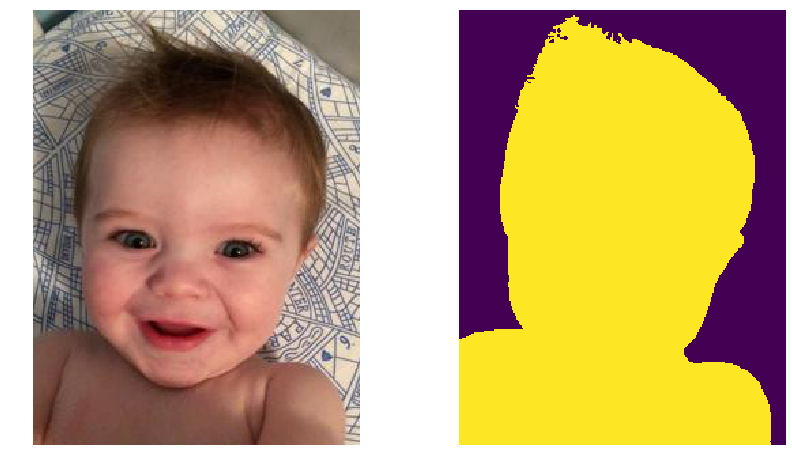

In [28]:
import random
ind = random.randint(0,1000)
decoded_mask = decode_rle(train_df.loc[ind][1])
show_img_with_mask(np.array(Image.open(f"{train_path}/{train_df.loc[ind][0]}.jpg")), decoded_mask)

In [0]:
def keras_generator(gen_df, batch_size, path):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread(f"{path}/{img_name}.jpg") #np.array(Image.open(f"{path}/{img_name}.jpg"))
            mask = decode_rle(mask_rle)
            
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [0]:
for x, y in keras_generator(train_df, 16, train_path):
    break

In [32]:
y.shape

(16, 256, 256, 1)

# Unet with resnet34

In [33]:
import segmentation_models as sm
from segmentation_models import unet

BACKBONE = 'resnet34'
preprocess_input = sm.backbones.get_preprocessing(BACKBONE)

/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [0]:
# load your data
#x_train, y_train, x_val, y_val = load_data(...)

In [0]:
# preprocess input
#x_train = preprocess_input(x_train)
#x_val = preprocess_input(x_val)

In [34]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score],
)








85524480/85521592 [==============================] - 2s 0us/step




In [0]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

In [37]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size, train_path),
              steps_per_epoch=100,
              epochs=10,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size, val_path),
              validation_steps=50,
              class_weight=None,
              max_queue_size=1,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/10
100/100 [==============================] - 2938s 29s/step - loss: 0.0927 - iou_score: 0.8407 - val_loss: 0.1179 - val_iou_score: 0.8031
Epoch 2/10
100/100 [==============================] - 2911s 29s/step - loss: 0.0564 - iou_score: 0.8984 - val_loss: 0.1371 - val_iou_score: 0.7726
Epoch 3/10
100/100 [==============================] - 2933s 29s/step - loss: 0.0492 - iou_score: 0.9118 - val_loss: 0.0999 - val_iou_score: 0.8304
Epoch 4/10
100/100 [==============================] - 2952s 30s/step - loss: 0.0450 - iou_score: 0.9175 - val_loss: 0.0487 - val_iou_score: 0.9106
Epoch 5/10
100/100 [==============================] - 2965s 30s/step - loss: 0.0369 - iou_score: 0.9315 - val_loss: 0.0534 - val_iou_score: 0.9060
Epoch 6/10
100/100 [==============================] - 2994s 30s/step - loss: 0.0319 - iou_score: 0.9406 - val_loss: 0.0466 - val_iou_score: 0.9159
Epoch 7/10
100/100 [==============================] - 2976s 30s/step - loss: 0.0312 - iou_score: 0.9415 - val_loss: 0.

In [0]:
pred = model.predict(x)

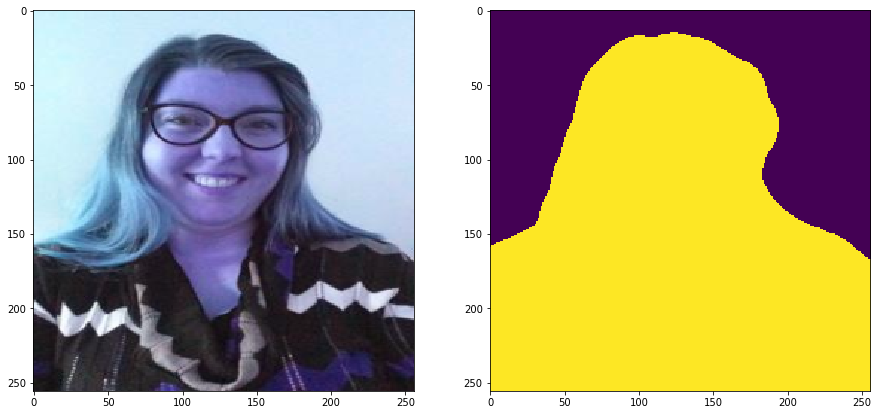

In [39]:

im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()